# Aaryan's Playground

### Installs

In [1]:
! pip install -q kaggle transformers datasets moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.6 MB/s eta 0:00:00


### Kaggle API Upload

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aryamankc","key":"6a9e258c8d9088c8b19bdecbb377f0b0"}'}

### Kaggle Dataset Download

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
# ! kaggle datasets download -d xhlulu/140k-real-and-fake-faces
! kaggle datasets download -d ciplab/real-and-fake-face-detection

100% 431M/431M [00:21<00:00, 24.3MB/s]
100% 431M/431M [00:21<00:00, 21.3MB/s]


In [6]:
# ! unzip 140k-real-and-fake-faces.zip

! unzip real-and-fake-face-detection.zip
! rm -r real_and_fake_face_detection

Archive:  real-and-fake-face-detection.zip
  inflating: real_and_fake_face/training_fake/easy_100_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_101_0010.jpg  
  inflating: real_and_fake_face/training_fake/easy_102_0101.jpg  
  inflating: real_and_fake_face/training_fake/easy_103_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_104_1000.jpg  
  inflating: real_and_fake_face/training_fake/easy_105_1100.jpg  
  inflating: real_and_fake_face/training_fake/easy_106_0011.jpg  
  inflating: real_and_fake_face/training_fake/easy_107_1011.jpg  
  inflating: real_and_fake_face/training_fake/easy_108_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_109_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_10_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_110_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_111_1101.jpg  
  inflating: real_and_fake_face/training_fake/easy_112_1001.jpg  
  inflating: real_and_fake_face/tr

In [7]:
# BASE_DIR = 'real_vs_fake/real-vs-fake'

BASE_DIR = 'real_and_fake_face'
! mv real_and_fake_face/training_fake real_and_fake_face/fake
! mv real_and_fake_face/training_real real_and_fake_face/real

### Imports

In [8]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Precision, Recall
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from tensorflow.image import resize
from tensorflow import cast
import matplotlib.pyplot as plt
from tensorflow import expand_dims
from moviepy.editor import VideoFileClip
from transformers import TFViTModel, ViTImageProcessor, DefaultDataCollator
from datasets import load_dataset
from tensorflow.keras.models import load_model
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

### Data Generator

#### CNN Models

In [ ]:
train_ds = image_dataset_from_directory(
    directory = BASE_DIR + '/train',
    labels='inferred',
    label_mode='binary',
    class_names=['fake', 'real'], # fake: 0, real: 1
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224), # change to 299, 299 for xception
    shuffle=True,
    seed = 123)

Found 100000 files belonging to 2 classes.


In [ ]:
test_ds = image_dataset_from_directory(
    directory = BASE_DIR + '/test',
    labels='inferred',
    label_mode='binary',
    class_names=['fake', 'real'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224), # change to 299, 299 for xception
    shuffle=True,
    seed = 123)

Found 20000 files belonging to 2 classes.


In [ ]:
valid_ds = image_dataset_from_directory(
    directory = BASE_DIR + '/valid',
    labels='inferred',
    label_mode='binary',
    class_names=['fake', 'real'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed = 123)

Found 20000 files belonging to 2 classes.


#### for testing on new dataset

In [9]:
test_ds = image_dataset_from_directory(
    directory = BASE_DIR,
    labels='inferred',
    label_mode='binary',
    class_names=['fake', 'real'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed = 123)

Found 2041 files belonging to 2 classes.


#### ViT Model

In [ ]:
vit_model = 'google/vit-base-patch16-224'
processor = ViTImageProcessor.from_pretrained(vit_model)
base_model = TFViTModel.from_pretrained(vit_model)

Some layers from the model checkpoint at google/vit-base-patch16-224 were not used when initializing TFViTModel: ['classifier']
- This IS expected if you are initializing TFViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
file = open('train_vit', 'rb')
train_dataset = pickle.load(file)
file.close()

file = open('valid_vit', 'rb')
valid_dataset = pickle.load(file)
file.close()

file = open('test_vit', 'rb')
test_dataset = pickle.load(file)
file.close()

FileNotFoundError: ignored

In [ ]:
train_dataset = load_dataset(BASE_DIR, data_dir='train')['train']
valid_dataset = load_dataset(BASE_DIR, data_dir="valid")['train']
test_dataset = load_dataset(BASE_DIR, data_dir='test')['train']

Resolving data files:   0%|          | 0/100000 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/real-vs-fake-ae534d764216a89d/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20000 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/real-vs-fake-542825d667e8e59f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20000 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/real-vs-fake-9ff4e75d30bca2f1/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
file = open('train_vit', 'wb')
pickle.dump(train_dataset, file, protocol=pickle.HIGHEST_PROTOCOL)
file.close()

file = open('test_vit', 'wb')
pickle.dump(test_dataset, file, protocol=pickle.HIGHEST_PROTOCOL)
file.close()

file = open('valid_vit', 'wb')
pickle.dump(valid_dataset, file, protocol=pickle.HIGHEST_PROTOCOL)
file.close()

In [ ]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']])
    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

train_ds = train_dataset.with_transform(transform)
test_ds = test_dataset.with_transform(transform)
valid_ds = valid_dataset.with_transform(transform)

In [ ]:
img_class_labels = test_ds.features["label"].names
img_class_labels

['fake', 'real']

In [ ]:
id2label = {str(i): label for i, label in enumerate(img_class_labels)}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
train_ds = train_ds.to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=32,
   collate_fn=data_collator)

test_ds = test_ds.to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=32,
   collate_fn=data_collator)

valid_ds = valid_ds.to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=32,
   collate_fn=data_collator)

### Samples in Training Set

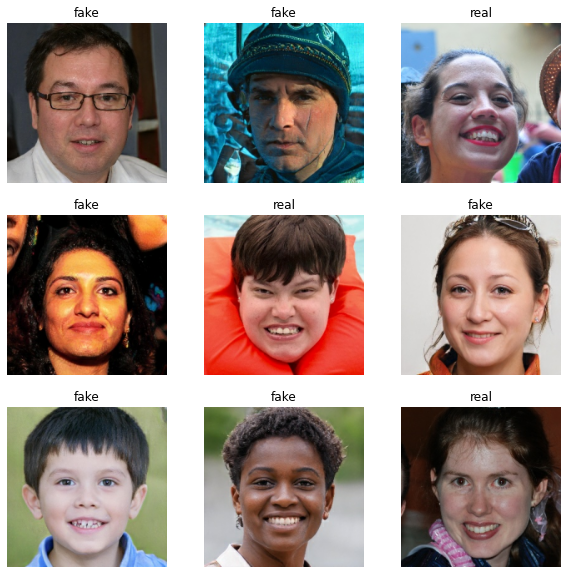

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[int(labels[i])])
    # plt.title(img_class_labels[int(labels[i])])
    plt.axis("off")

### Load the Model

In [ ]:
# model = load_model('resnet_based.h5')
# model = load_model('vgg16_based.h5')
model = load_model('xception_based.h5')
# model = load_model('vit_based.h5')

### Model Architecture and Training

In [ ]:
# resnet
# input = Input(shape = (224, 224, 3), batch_size = 32, name = 'input') 
# x = resnet_preprocess(input)
# x = ResNet50(weights = 'imagenet', include_top = False, pooling = 'avg')(x)
# output = Dense(1, activation='sigmoid')(x)

# vgg16
# input = Input(shape = (224, 224, 3), batch_size = 32, name = 'input') 
# x = vgg16_preprocess(input)
# x = VGG16(weights = 'imagenet', include_top = False, pooling = 'avg')(x)
# output = Dense(1, activation='sigmoid')(x)

# xception
# input = Input(shape = (299, 299, 3), batch_size = 32, name = 'input') 
# x = xception_preprocess(input)
# x = Xception(weights = 'imagenet', include_top = False, pooling = 'avg')(x)
# output = Dense(1, activation='sigmoid')(x)

# vit
input = Input(shape = (3, 224, 224), batch_size = 32, name = 'input')
base_model.trainable = False
vit = base_model.vit(input)['last_hidden_state']
output = Dense(1, activation='sigmoid')(vit[:,0,:])

model = Model(input, output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(32, 3, 224, 224)]       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             32, 197, 768),                      
                              pooler_output=(32, 768)            
                             , hidden_states=None, at            
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (S  (32, 768)                0         
 licingOpLambda)                                                 
                                                                 
 dense (Dense)               (32, 1)                   769   

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy', TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives(), Precision(), Recall()]
)

In [ ]:
train_steps = 100000//32
valid_steps = 20000//32

history = model.fit(
    train_ds,
    epochs = 2,
    steps_per_epoch = train_steps,
    validation_data = valid_ds,
    validation_steps = valid_steps
)

Epoch 1/2
3125/3125 [==============================] - 3218s 1s/step - loss: 0.2905 - accuracy: 0.8783 - true_positives: 43270.0000 - true_negatives: 44559.0000 - false_positives: 5441.0000 - false_negatives: 6730.0000 - precision: 0.8883 - recall: 0.8654 - val_loss: 0.2378 - val_accuracy: 0.9029 - val_true_positives: 8759.0000 - val_true_negatives: 9300.0000 - val_false_positives: 700.0000 - val_false_negatives: 1241.0000 - val_precision: 0.9260 - val_recall: 0.8759
Epoch 2/2
3125/3125 [==============================] - 3250s 1s/step - loss: 0.2236 - accuracy: 0.9104 - true_positives: 45136.0000 - true_negatives: 45899.0000 - false_positives: 4101.0000 - false_negatives: 4864.0000 - precision: 0.9167 - recall: 0.9027 - val_loss: 0.2189 - val_accuracy: 0.9113 - val_true_positives: 8973.0000 - val_true_negatives: 9253.0000 - val_false_positives: 747.0000 - val_false_negatives: 1027.0000 - val_precision: 0.9231 - val_recall: 0.8973


### Save the Model

In [ ]:
# model.save('resnet_based.h5')
# model.save('vgg16_based.h5')
# model.save('xception_based.h5')
model.save('vit_based.h5')

### Plot

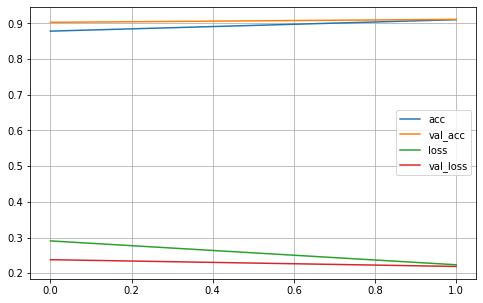

In [ ]:
# Plot losses and accuracies
fig = plt.figure(figsize = (8, 5))
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.grid()
plt.legend()
plt.show()

### Test Dataset Evaluation

In [ ]:
model.evaluate(test_ds)

64/64 [==============================] - 461s 7s/step - loss: 3.3171 - accuracy: 0.5292 - true_positives: 1079.0000 - true_negatives: 1.0000 - false_positives: 959.0000 - false_negatives: 2.0000 - precision: 0.5294 - recall: 0.9981


[3.317091464996338,
 0.5291523933410645,
 1079.0,
 1.0,
 959.0,
 2.0,
 0.5294406414031982,
 0.9981498718261719]

### Try on your photo

In [ ]:
from google.colab import files

files.upload();

Saving Screenshot_2023-02-20-17-32-10-45_1c337646f29875672b5a61192b9010f9.jpg to Screenshot_2023-02-20-17-32-10-45_1c337646f29875672b5a61192b9010f9.jpg
Saving v3_0881290.jpg to v3_0881290.jpg
Saving WhatsApp Image 2023-03-13 at 00.45.29.jpg to WhatsApp Image 2023-03-13 at 00.45.29.jpg


In [ ]:
! mkdir images
! mv *.jpg images

UPLOAD_DIR = 'images'

1/1 [==============================] - 1s 682ms/step


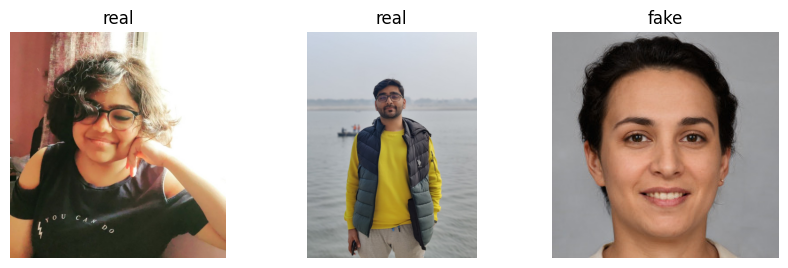

In [ ]:
plt.figure(figsize=(10, 10))
i = 0
for image in os.listdir(UPLOAD_DIR):
  image_path = os.path.join(UPLOAD_DIR, image)
  if os.path.isfile(image_path):
    ax = plt.subplot(3, 3, i + 1)
    plt.axis("off")
    i = i + 1
    image = load_img(
      image_path
    )

    # cnn
    img_array = img_to_array(image)
    img_array = resize(image, [299, 299])
    img_array = cast(img_array, tf.int32)
    img_array = expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    
    # vit
    # inputs = processor(image, return_tensors="tf")['pixel_values']
    # predictions = model(inputs)
    
    answer = 'real' if predictions[0] >= 0.5 else 'fake'
    plt.title(answer)
    plt.imshow(image)

### Try on Video

In [ ]:
from google.colab import files

files.upload();

Saving Deepfake Morgan Freeman.mp4 to Deepfake Morgan Freeman.mp4


In [ ]:
! mkdir videos
! mv *.mp4 videos

UPLOAD_DIR = 'videos'

1/1 [==============================] - 1s 704ms/step


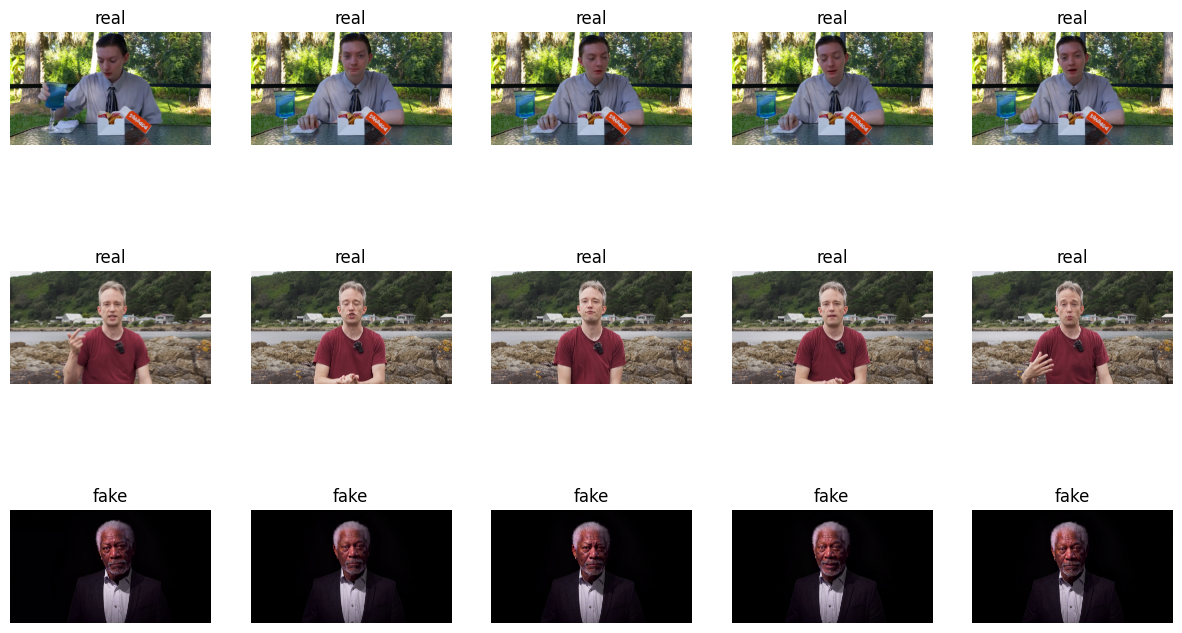

In [ ]:
plt.figure(figsize=(15, 15))
i = 0

for video in os.listdir(UPLOAD_DIR):
  video_path = os.path.join(UPLOAD_DIR, video)
  clip = VideoFileClip(video_path)
  duration = clip.duration
  number_of_images = 5
  frameRate = duration / number_of_images
  for timestamp in np.arange(0, duration, frameRate):
    frame = clip.get_frame(timestamp)
    ax = plt.subplot(number_of_images, number_of_images, i + 1)
    plt.axis("off")
    i = i + 1

    # cnn
    frame_array = resize(frame, [299, 299])
    frame_array = cast(frame_array, tf.int32)
    frame_array = expand_dims(frame_array, 0)
    predictions = model.predict(frame_array)
    
    # vit
    # inputs = processor(image, return_tensors="tf")['pixel_values']
    # predictions = model(inputs)
    
    answer = 'real' if predictions[0] >= 0.5 else 'fake'
    plt.title(answer)
    plt.imshow(frame)